# Installing packages


In [14]:
%pip install qiskit
%pip install qiskit_algorithms
%pip install qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Setting up the global seed to ensure reproducibility

In [15]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 12345

# Classification

## Defining the dataset

In [16]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

## Defining utility functions to plot the dataset

In [17]:
import matplotlib.pyplot as plt
import numpy as np
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

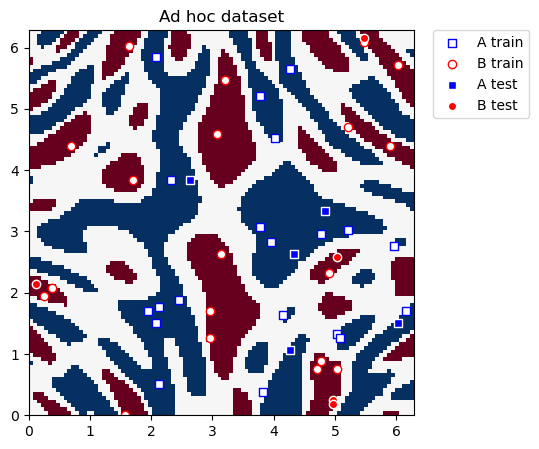

In [18]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

## Defining the quantum kernel


In [19]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_Zfeature_map = ZFeatureMap(feature_dimension=adhoc_dimension, reps=2)
adhoc_ZZfeature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel_Z = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_Zfeature_map)
adhoc_kernel_ZZ = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_ZZfeature_map)

## Classification with SVC

### Kernel as a callable function

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score

adhoc_svc_Z = SVC(kernel=adhoc_kernel_Z.evaluate)
adhoc_svc_ZZ = SVC(kernel=adhoc_kernel_ZZ.evaluate)

adhoc_svc_Z.fit(train_features, train_labels)
adhoc_svc_ZZ.fit(train_features, train_labels)

adhoc_score_callable_function_Z = adhoc_svc_Z.score(test_features, test_labels)
adhoc_score_callable_function_ZZ = adhoc_svc_ZZ.score(test_features, test_labels)

predicted_labels_callable_Z = adhoc_svc_Z.predict(test_features)
predicted_labels_callable_ZZ = adhoc_svc_ZZ.predict(test_features)

callable_precision_score_Z = precision_score(test_labels, predicted_labels_callable_Z)
callable_precision_score_ZZ = precision_score(test_labels, predicted_labels_callable_ZZ)


print(f"Callable kernel classification test score using Z Feature Map: {adhoc_score_callable_function_Z}")
print(f"Callable kernel classification test score using ZZ Feature Map: {adhoc_score_callable_function_ZZ}")

Callable kernel classification test score using Z Feature Map: 0.7
Callable kernel classification test score using ZZ Feature Map: 1.0


### Precomputed kernel matrix

In [21]:
adhoc_matrix_train_Z = adhoc_kernel_Z.evaluate(x_vec=train_features)
adhoc_matrix_train_ZZ = adhoc_kernel_ZZ.evaluate(x_vec=train_features)

adhoc_matrix_test_Z = adhoc_kernel_Z.evaluate(x_vec=test_features, y_vec=train_features)
adhoc_matrix_test_ZZ = adhoc_kernel_ZZ.evaluate(x_vec=test_features, y_vec=train_features)

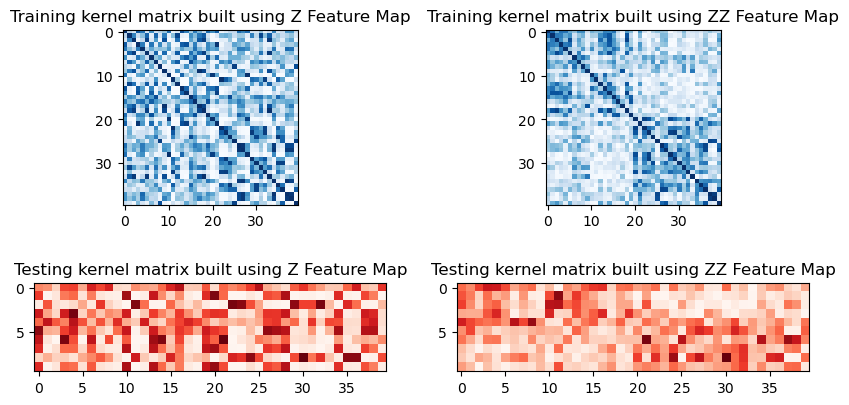

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0, 0].imshow(np.asmatrix(adhoc_matrix_train_Z), interpolation="nearest", origin="upper", cmap="Blues")
axs[0, 0].set_title("Training kernel matrix built using Z Feature Map")
axs[0, 1].imshow(np.asmatrix(adhoc_matrix_train_ZZ), interpolation="nearest", origin="upper", cmap="Blues")
axs[0, 1].set_title("Training kernel matrix built using ZZ Feature Map")


axs[1, 0].imshow(np.asmatrix(adhoc_matrix_test_Z), interpolation="nearest", origin="upper", cmap="Reds")
axs[1, 0].set_title("Testing kernel matrix built using Z Feature Map")

axs[1, 1].imshow(np.asmatrix(adhoc_matrix_test_ZZ), interpolation="nearest", origin="upper", cmap="Reds")
axs[1, 1].set_title("Testing kernel matrix built using ZZ Feature Map")

plt.show()

In [23]:
from sklearn.metrics import precision_score

adhoc_svc_Z = SVC(kernel="precomputed")
adhoc_svc_ZZ = SVC(kernel="precomputed")

adhoc_svc_Z.fit(adhoc_matrix_train_Z, train_labels)
adhoc_svc_ZZ.fit(adhoc_matrix_train_ZZ, train_labels)

adhoc_score_precomputed_kernel_Z = adhoc_svc_Z.score(adhoc_matrix_test_Z, test_labels)
adhoc_score_precomputed_kernel_ZZ = adhoc_svc_ZZ.score(adhoc_matrix_test_ZZ, test_labels)

predicted_labels_precomputed_kernel_Z = adhoc_svc_Z.predict(adhoc_matrix_test_Z)
predicted_labels_precomputed_kernel_ZZ = adhoc_svc_ZZ.predict(adhoc_matrix_test_ZZ)

precomputed_kernel_precision_score_Z = precision_score(test_labels, predicted_labels_precomputed_kernel_Z)
precomputed_kernel_precision_score_ZZ = precision_score(test_labels, predicted_labels_precomputed_kernel_ZZ)

print(f"Precomputed kernel classification test score using Z Feature Map: {adhoc_score_precomputed_kernel_Z}")
print(f"Precomputed kernel classification test score using Z Feature Map: {adhoc_score_precomputed_kernel_ZZ}")

Precomputed kernel classification test score using Z Feature Map: 0.7
Precomputed kernel classification test score using Z Feature Map: 1.0


## Classification with QSVC

In [24]:
from qiskit_machine_learning.algorithms import QSVC
from sklearn.metrics import precision_score

qsvc_Z = QSVC(quantum_kernel=adhoc_kernel_Z)
qsvc_ZZ = QSVC(quantum_kernel=adhoc_kernel_ZZ)

qsvc_Z.fit(train_features, train_labels)
qsvc_ZZ.fit(train_features, train_labels)

qsvc_score_Z = qsvc_Z.score(test_features, test_labels)
qsvc_score_ZZ = qsvc_ZZ.score(test_features, test_labels)

predicted_labels_QSVC_Z = qsvc_Z.predict(test_features)
predicted_labels_QSVC_ZZ = qsvc_ZZ.predict(test_features)

QSVC_precision_score_Z = precision_score(test_labels, predicted_labels_QSVC_Z)
QSVC_precision_score_ZZ = precision_score(test_labels, predicted_labels_QSVC_ZZ)

print(f"QSVC classification test score using Z Feature Map: {qsvc_score_Z}")
print(f"QSVC classification test score using ZZ Feature Map: {qsvc_score_ZZ}")

QSVC classification test score using Z Feature Map: 0.7
QSVC classification test score using ZZ Feature Map: 1.0


## Evaluation of models used for classification

In [47]:
print(f"Classification Model                                           | Accuracy Score | Precision Score")
print(f"---------------------------------------------------------")
print(f"SVC using Z Feature Map and the Kernel as a callable function  | {adhoc_score_callable_function_Z:10.2f}     | {callable_precision_score_Z:10.2f}")
print(f"SVC using ZZ Feature Map and the kernel as a callable function | {adhoc_score_callable_function_ZZ:10.2f}     | {callable_precision_score_ZZ:10.2f}")
print(f"SVC using Z Feature Map and the precomputed kernel matrix      | {adhoc_score_precomputed_kernel_Z:10.2f}     | {precomputed_kernel_precision_score_Z:10.2f}")
print(f"SVC using ZZ Feature Map and the precomputed kernel matrix     | {adhoc_score_precomputed_kernel_ZZ:10.2f}     | {precomputed_kernel_precision_score_ZZ:10.2f}")
print(f"QSVC using Z Feature Map                                       | {qsvc_score_Z:10.2f}     | {QSVC_precision_score_Z:10.2f}")                    
print(f"QSVC using ZZ Feature Map                                      | {qsvc_score_ZZ:10.2f}     | {QSVC_precision_score_ZZ:10.2f}")  

Classification Model                                           | Accuracy Score | Precision Score
---------------------------------------------------------
SVC using Z Feature Map and the Kernel as a callable function  |       0.70     |       0.67
SVC using ZZ Feature Map and the kernel as a callable function |       1.00     |       1.00
SVC using Z Feature Map and the precomputed kernel matrix      |       0.70     |       0.67
SVC using ZZ Feature Map and the precomputed kernel matrix     |       1.00     |       1.00
QSVC using Z Feature Map                                       |       0.70     |       0.67
QSVC using ZZ Feature Map                                      |       1.00     |       1.00
